# Portfolio Blog

# Traditional Chinese Calligraphy Recognition Using CNN
This is the portfolio blog for INFO 7390 Spring instructed by Prof. Nik Brown.<br>By Houze Liu: [liu.hou@husky.neu.edu](mailto:liu.hou@husky.neu.edu) / <a href="https://github.com/HouHouHouHouHouHou">github</a>

## Introduction
This blog is about to recognize 40 different Traditional Chinese Characters(TCC) using Convolutional Neural Network(CNN).

In this blog, we will implement different CNN on our dataset and evaluate their performance by accuracy on classification. The plateform we will use is PyTorch, which is easier to learn compared to TensorFlow.

Convolutional Neural Networks(CNN) work by moving small filters across an input image. One filter can be regarded as a reception. It acts like a sight neure which 'sees' one part of input image one time, and can get activated accordingly. This makes Convolutional Netwroks very powerful on capturing patterns, and thus can keep more complex information than simple multilayer perceptrons(MLP). The differenc between CNN and MLP is that CNN has convolution layers. Besides, MLP has the layers same with the CNN's rest layers (we call them fully connected layers, or FC layers in terms of CNN). <br>reference: http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture5.pdf

![Convolution Layer1](images/image3.jpeg)
![Convolution Layer2](images/image2.jpeg)
The numer of filters we use to convolve the input image euqals the number of 'stacks' of the output activation maps. That gave us a new input with more channels and usually smaller size. 
![Convolution Layer3](images/image1.jpeg)

![](/images/image1)

## Imports

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
import os
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import time

This was developed using Python 2.7 (Anaconda) and PyTorch version:

In [5]:
torch.__version__

'0.3.1.post2'

## Load data

Out data-set is about 833.8 MB and should be put in the same file with this notebook.<br>'Train', 'Test' and 'Validation' make up the data file. They are divided by 8 : 1 : 1.

In [5]:
batch_size = 100#batch_size will be used to get accuracy
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(96),
        transforms.CenterCrop(128),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(96),
        transforms.CenterCrop(128),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(96),
        transforms.CenterCrop(128),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','test','validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True,num_workers=4)
              for x in ['train','test','validation']}

In [3]:
print("Length of Training-set:\t\t {}\nLength of Test-set:\t\t {}\nLength of Validation-set:\t {}".format(
    len(dataloaders['train'])*batch_size,
    len(dataloaders['test'])*batch_size,
    len(dataloaders['validation'])*batch_size))

Length of Training-set:		 38000
Length of Test-set:		 1000
Length of Validation-set:	 1000


## Plot some images

First, we reload our data in numpy-array, so that we can use skimage to visualize those more easily.<br>For this part of code see reference:https://www.datacamp.com/community/tutorials/tensorflow-tutorial

In [6]:
import skimage
from skimage import data

def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".jpg")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(d)
    return images, labels

test_data_directory = "data/test"

images, labels = load_data(test_data_directory)

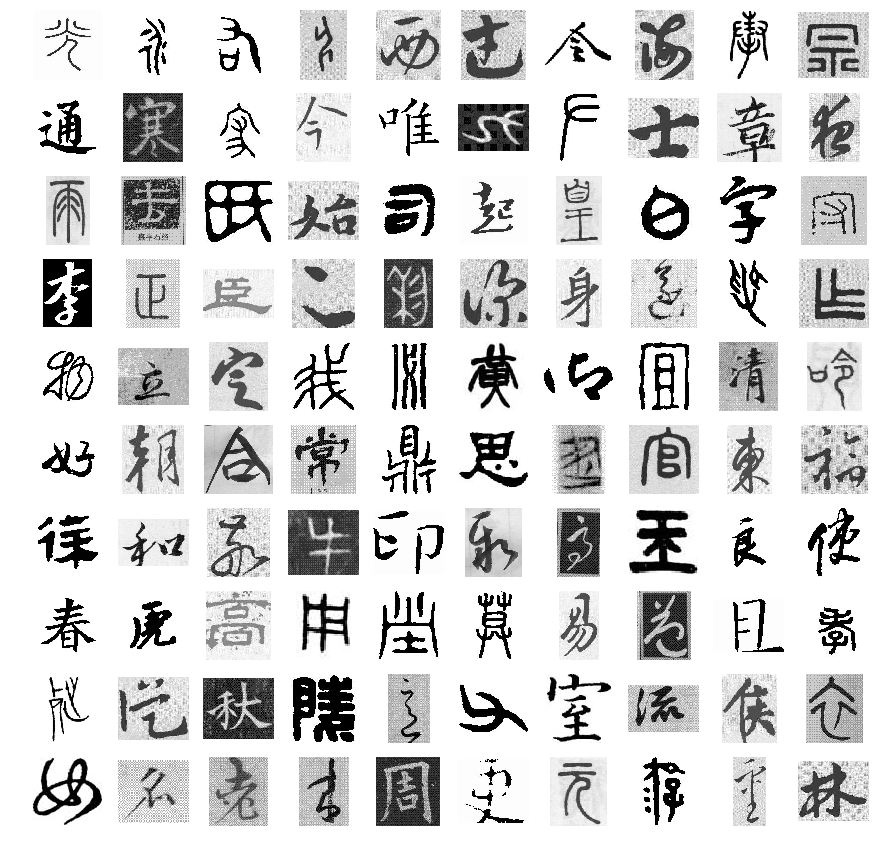

In [35]:
from skimage.color import rgb2gray

# Get the unique labels 
unique_labels = set(labels)

# Initialize the figure
plt.figure(figsize=(15, 15))

# Set a counter
i = 1

# For each unique label,
for label in unique_labels:
    # You pick the first image for each label
    image = rgb2gray(images[labels.index(label)])
    # Define 100 subplots 
    plt.subplot(10, 10, i)
    # Don't include axes
    plt.axis('off')
    # Add a title to each subplot 
    # Add 1 to the counter
    i += 1
    # And you plot this first image 
    plt.imshow(image, cmap = "gray")
    
# Show the plot
plt.show()

Let's see how our transform functions do to our images:

First, we load a image, which is the 9th image of class 'guang' in our test-set

(243, 190)


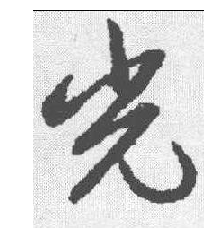

In [46]:
label = 'guang' 
index = labels.index(label)
image1 = rgb2gray(images[index+9-1])
plt.axis('off')
plt.imshow(image1, cmap = 'gray')
print(image1.shape)

Now, we turn it to PIL image

Size: 243x190


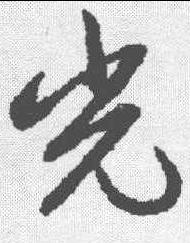

In [48]:
import PIL
from PIL import Image,ImageOps

image_1 = Image.fromarray(image1)
print("Size: {}x{}".format(image1.shape[0],image1.shape[1]))
image_1

This is what the image will look like after a transform of Resize(96) 

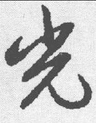

In [49]:
image_2 = image_1.resize((96,123), PIL.Image.ANTIALIAS)#123 = 243*96/190
image_2

After the transform of CenterCrop(128)

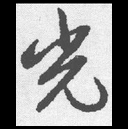

In [53]:
image_3_data = np.pad(np.array(image_2.getdata(),dtype = 'uint8').reshape(123,96),((3,3),(16,16)),'constant')
image_3 = Image.fromarray(image_3_data)
image_3

Let's see some images more clearly. You can play with them too.

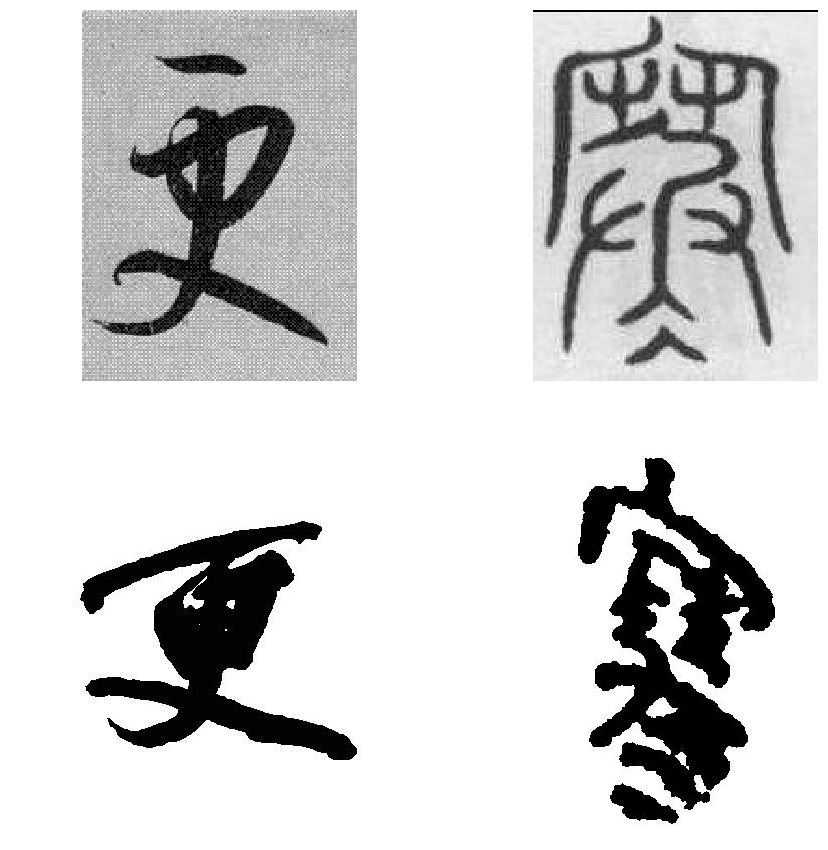

In [57]:
label = 'han'#choose whatever label you like from label list. You can run: set(labels) to see all lable names
index = labels.index(label)
plt.figure(figsize=(15, 15))
image1 = rgb2gray(images[index+3-1])
image2 = rgb2gray(images[index+4-1])
image3 = rgb2gray(images[index+13-1])
image4 = rgb2gray(images[index+14-1])
plt.subplot(2, 2, 2)
plt.axis('off')
plt.imshow(image1, cmap = 'gray')
plt.subplot(2, 2, 4)
plt.axis('off')
plt.imshow(image2, cmap = 'gray')
plt.subplot(2, 2, 1)
plt.axis('off')
plt.imshow(image3, cmap = 'gray')
plt.subplot(2, 2, 3)
plt.axis('off')
plt.imshow(image4, cmap = 'gray')

## An Overview of PyTorch
PyTorch is a python based library built to provide flexibility as a deep learning development platform. The workflow of PyTorch is as close as you can get to python’s scientific computing library – numpy.

Now you might ask, why would we use PyTorch to build deep learning models? I can list down three things that might help answer that:

    Easy to use API – It is as simple as python can be.
    Python support – As mentioned above, PyTorch smoothly integrates with the python data science stack. It is so similar to numpy that you might not even notice the difference.
    Dynamic computation graphs – Instead of predefined graphs with specific functionalities, PyTorch provides a framework for us to build computational graphs as we go, and even change them during runtime. This is valuable for situations where we don’t know how much memory is going to be required for creating a neural network.

A few other advantages of using PyTorch are it’s multiGPU support, custom data loaders and simplified preprocessors.
<br>reference: https://www.analyticsvidhya.com/blog/2018/02/pytorch-tutorial/

## Some difference between PyTorch and TensorFlow
In TensorFlow, one must first design the model by running some kind of declarative code and then run it using so called tf.Sessions. In practice, it makes it harder to debug and really experiment with it. On the other hand, pytorch is dynamic, it runs a more procedural way, which allows to look inside the box and see what’s going on at intermediate step. <br>reference: https://www.quora.com/Should-I-go-for-TensorFlow-or-PyTorch

## Let's construct our Convolutional Network

## Important: If Your Devices Support GPU, Please Remove # Before .cuda( ) TO Use GPU
Below will return True if your devices support GPU

In [2]:
torch.cuda.is_available()

False

We defined a model with 3 convolutional layer, 3 FC layers, so 6 layers in total.<br>For every conv layer, we will double channels, keep feature maps using filter of 3x3, pad 1, stride 1. After every conv layer, we add a pooling layer. For activation funciton, we use ReLu. At the last layer of FC layer, we will use a softmax classfier.<br>For more details, please refer to my paper.

In [7]:
class ConvNet_L6(nn.Module):#this model is same as model_l6_fc_1, we rename it as ConvNet_L6 to keep consistency with annotation on paper
    def __init__(self):
        super(ConvNet_L6, self).__init__()
        self.all_losses = []
        self.test_accuracy = []
        self.train_accuracy = []
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.fc1 = nn.Linear(16*16*128,1024)#compared to model_l6 in the previous step, model_l6_fc_1 only changes FC layers
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 100)

    def forward(self, x):
        x = x.view(-1,1,128,128)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2, 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2, 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2, 2)
        x = x.view(-1, 16*16*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

### Helper Function That Helps Get Accuracy
This function can give you prediction accuracy of your model and data-set fed in. We will use it to get and display accuracy on test-set.

In [8]:
def AccuracyHelper(model,dataset):
    count = 0
    for batch_idx, (data,target) in enumerate(dataset):
        data, target = Variable(data#.cuda()
                               ), Variable(target#.cuda()
                                          )
        y_pred = model(data)#model
        prediction = torch.max(F.softmax(y_pred, dim = 1), 1)[1]
        pred_y = prediction.cpu().data.numpy().squeeze()
        target_y = target.cpu().data.numpy()
        count += sum(pred_y == target_y)
    accuracy = float(count)/float(batch_size*len(dataset))
    model.test_accuracy.append(accuracy)
    print('accuracy on test set: {:.3f}%'.format(100*accuracy),count)

Training process.

In [9]:
class Training():
    def __init__(self,dataloaders,ConvNet,lr = 0.01, epoch = 10):
        self.criteria = nn.CrossEntropyLoss()
        self.model = ConvNet
        self.optimizer = optim.SGD(ConvNet.parameters(), lr=lr, momentum=0.9)
        self.log_interval=10#log_interval * batch_size = the number of displayed samples
        self.epoch = epoch
        self.data = dataloaders
        self.ConvNet = ConvNet
        
    def start(self):
        for epoch in range(self.epoch):#set epoch of iteration
            for batch_idx, (data,target) in enumerate(self.data['train']):
                data, target = Variable(data#.cuda()
                                       ), Variable(target#.cuda()
                                                  )#turn x,y from tensors to Variables
                y_pred = self.model(data)#feed x, return prediction on the sample
                prediction = torch.max(F.softmax(y_pred), 1)[1]
                pred_y = prediction.cpu().data.numpy().squeeze()
                target_y = target.cpu().data.numpy()
                loss = self.criteria(y_pred, target)#cal loss
                self.optimizer.zero_grad()#set all gradient to 0
                loss.backward()#begin backprop
                self.optimizer.step()#cal grad
                if batch_idx % self.log_interval == 0:#display progress
                    accuracy = sum(pred_y == target_y) / 100.0
                    self.ConvNet.all_losses.append(loss.data[0])
                    self.ConvNet.train_accuracy.append(accuracy)
                    print('Train Epoch: {} [{}/{} ({:.3f}%)]\tLoss: {:.6f}\tAccuracy: {:.3f}'.format(
                        epoch, batch_size*batch_idx, batch_size*len(self.data['train']),
                        100. * batch_idx / len(self.data['train']), loss.data[0], accuracy))
            AccuracyHelper(self.model,self.data['test'])

create model instance

In [10]:
model_l6  = ConvNet_L6()
# model_l6.cuda()

ConvNet_L6(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=100, bias=True)
)

start

In [11]:
start_time = time.time()
train = Training(dataloaders, model_l6, 0.01)
train.start()
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/miniconda3/envs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Train Epoch: 0 [0/38000 (0.000%)]	Loss: 4.611240	Accuracy: 0.020
Train Epoch: 0 [1000/38000 (2.632%)]	Loss: 4.610636	Accuracy: 0.000
Train Epoch: 0 [2000/38000 (5.263%)]	Loss: 4.603180	Accuracy: 0.010
Train Epoch: 0 [3000/38000 (7.895%)]	Loss: 4.600717	Accuracy: 0.010
Train Epoch: 0 [4000/38000 (10.526%)]	Loss: 4.602985	Accuracy: 0.020
Train Epoch: 0 [5000/38000 (13.158%)]	Loss: 4.599448	Accuracy: 0.040
Train Epoch: 0 [6000/38000 (15.789%)]	Loss: 4.599238	Accuracy: 0.010
Train Epoch: 0 [7000/38000 (18.421%)]	Loss: 4.602567	Accuracy: 0.020
Train Epoch: 0 [8000/38000 (21.053%)]	Loss: 4.609653	Accuracy: 0.000
Train Epoch: 0 [9000/38000 (23.684%)]	Loss: 4.602873	Accuracy: 0.020
Train Epoch: 0 [10000/38000 (26.316%)]	Loss: 4.592177	Accuracy: 0.070
Train Epoch: 0 [11000/38000 (28.947%)]	Loss: 4.594704	Accuracy: 0.020
Train Epoch: 0 [12000/38000 (31.579%)]	Loss: 4.601191	Accuracy: 0.010
Train Epoch: 0 [13000/38000 (34.211%)]	Loss: 4.597754	Accuracy: 0.000
Train Epoch: 0 [14000/38000 (36.842%)

Train Epoch: 3 [3000/38000 (7.895%)]	Loss: 0.802138	Accuracy: 0.830
Train Epoch: 3 [4000/38000 (10.526%)]	Loss: 0.683575	Accuracy: 0.800
Train Epoch: 3 [5000/38000 (13.158%)]	Loss: 0.883142	Accuracy: 0.780
Train Epoch: 3 [6000/38000 (15.789%)]	Loss: 0.674192	Accuracy: 0.780
Train Epoch: 3 [7000/38000 (18.421%)]	Loss: 0.866854	Accuracy: 0.730
Train Epoch: 3 [8000/38000 (21.053%)]	Loss: 0.944603	Accuracy: 0.770
Train Epoch: 3 [9000/38000 (23.684%)]	Loss: 1.133778	Accuracy: 0.730
Train Epoch: 3 [10000/38000 (26.316%)]	Loss: 1.095206	Accuracy: 0.710
Train Epoch: 3 [11000/38000 (28.947%)]	Loss: 0.965592	Accuracy: 0.720
Train Epoch: 3 [12000/38000 (31.579%)]	Loss: 0.866750	Accuracy: 0.770
Train Epoch: 3 [13000/38000 (34.211%)]	Loss: 0.765683	Accuracy: 0.850
Train Epoch: 3 [14000/38000 (36.842%)]	Loss: 0.923003	Accuracy: 0.770
Train Epoch: 3 [15000/38000 (39.474%)]	Loss: 0.893328	Accuracy: 0.790
Train Epoch: 3 [16000/38000 (42.105%)]	Loss: 0.798215	Accuracy: 0.820
Train Epoch: 3 [17000/38000 

Train Epoch: 6 [6000/38000 (15.789%)]	Loss: 0.331035	Accuracy: 0.930
Train Epoch: 6 [7000/38000 (18.421%)]	Loss: 0.149061	Accuracy: 0.940
Train Epoch: 6 [8000/38000 (21.053%)]	Loss: 0.131350	Accuracy: 0.950
Train Epoch: 6 [9000/38000 (23.684%)]	Loss: 0.113063	Accuracy: 0.960
Train Epoch: 6 [10000/38000 (26.316%)]	Loss: 0.151557	Accuracy: 0.950
Train Epoch: 6 [11000/38000 (28.947%)]	Loss: 0.105711	Accuracy: 0.940
Train Epoch: 6 [12000/38000 (31.579%)]	Loss: 0.071895	Accuracy: 0.980
Train Epoch: 6 [13000/38000 (34.211%)]	Loss: 0.100111	Accuracy: 0.960
Train Epoch: 6 [14000/38000 (36.842%)]	Loss: 0.088981	Accuracy: 0.970
Train Epoch: 6 [15000/38000 (39.474%)]	Loss: 0.145859	Accuracy: 0.970
Train Epoch: 6 [16000/38000 (42.105%)]	Loss: 0.145890	Accuracy: 0.950
Train Epoch: 6 [17000/38000 (44.737%)]	Loss: 0.065532	Accuracy: 0.970
Train Epoch: 6 [18000/38000 (47.368%)]	Loss: 0.159400	Accuracy: 0.950
Train Epoch: 6 [19000/38000 (50.000%)]	Loss: 0.120336	Accuracy: 0.980
Train Epoch: 6 [20000/38

Train Epoch: 9 [9000/38000 (23.684%)]	Loss: 0.101560	Accuracy: 0.960
Train Epoch: 9 [10000/38000 (26.316%)]	Loss: 0.030505	Accuracy: 0.990
Train Epoch: 9 [11000/38000 (28.947%)]	Loss: 0.076813	Accuracy: 0.950
Train Epoch: 9 [12000/38000 (31.579%)]	Loss: 0.003037	Accuracy: 1.000
Train Epoch: 9 [13000/38000 (34.211%)]	Loss: 0.011802	Accuracy: 1.000
Train Epoch: 9 [14000/38000 (36.842%)]	Loss: 0.028194	Accuracy: 0.990
Train Epoch: 9 [15000/38000 (39.474%)]	Loss: 0.094540	Accuracy: 0.960
Train Epoch: 9 [16000/38000 (42.105%)]	Loss: 0.054120	Accuracy: 0.990
Train Epoch: 9 [17000/38000 (44.737%)]	Loss: 0.020756	Accuracy: 1.000
Train Epoch: 9 [18000/38000 (47.368%)]	Loss: 0.141031	Accuracy: 0.980
Train Epoch: 9 [19000/38000 (50.000%)]	Loss: 0.030390	Accuracy: 1.000
Train Epoch: 9 [20000/38000 (52.632%)]	Loss: 0.061741	Accuracy: 0.980
Train Epoch: 9 [21000/38000 (55.263%)]	Loss: 0.045756	Accuracy: 0.990
Train Epoch: 9 [22000/38000 (57.895%)]	Loss: 0.071833	Accuracy: 0.980
Train Epoch: 9 [23000

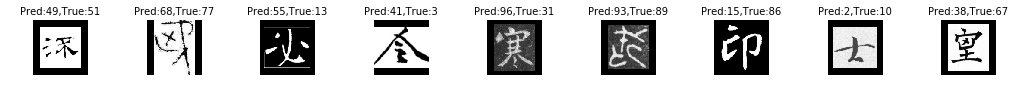

In [29]:
pltsize=1
plt.figure(figsize=(20*pltsize, pltsize))

count = 0
validate_data = dataloaders['test']
for batch_idx, (x,y) in enumerate(validate_data):
    xv= Variable(x#.cuda()
                )
    topk_n, topk_i = model_l6(xv).data.topk(1)
    for i in range(batch_size):
        if (topk_i[i][0] != y[i]) & (count < 9):
            count +=1 
            plt.subplot(1,10,count)
            plt.axis('off')
            image = x[i].numpy().reshape(128,128)
            plt.imshow(image, cmap="gray")
            plt.title("Pred:{},True:{}".format(topk_i[i][0],y[i]),fontsize=10)

## Tuning Your Model
In order to acheive better performance of your model, tuning is necessary. Basically, it means changing some variables that are not in-model variables. We call those out-model variables hyper-parameters in contrast to parameters which are exactly what's inside every filters. When we scan the image with a filter, the result is the matrix product by the parameters of this filter and by the values of the image within the inception field. Those parameters are fixed. Other changeable parameters include learning-rate, how many epochs you train, network structures(how many layers, and how many channels each layer), and other optimizations like momentum, SGD, Adam, etc.. We will change our network archetecture and then try different learning rate to see if we can get higher accuracy on both training set and test-set and to evaluate how quickly different models plateu with losses.

#### *tips: only change ONE hyper-parameter one time

### Another Convolutional Network With More Conv-Layers

We add one Conv-layer to ConvNet_L6, so that we name our new model ConvNet_L7.

In [13]:
class ConvNet_L7(nn.Module):
    def __init__(self):
        super(ConvNet_L7, self).__init__()
        self.all_losses = []
        self.test_accuracy = []
        self.train_accuracy = []
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, 1)#We add a Conv-layer with input 128 and output 256
        self.fc1 = nn.Linear(8*8*256,1024)#Since we changed output channels fromn 128 to 256, and have one more max-pooling
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 100)

    def forward(self, x):
        x = x.view(-1,1,128,128)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2, 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2, 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2, 2)        
        x = F.max_pool2d(F.relu(self.conv4(x)), 2, 2)#consistency to conv4
        x = x.view(-1, 8*8*256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

In [14]:
model_l7  = ConvNet_L7()
# model_l7.cuda()

ConvNet_L7(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=100, bias=True)
)

In [15]:
start_time = time.time()
train = Training(dataloaders, model_l7, 0.01)
train.start()
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/miniconda3/envs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Train Epoch: 0 [0/38000 (0.000%)]	Loss: 4.604363	Accuracy: 0.000
Train Epoch: 0 [1000/38000 (2.632%)]	Loss: 4.604963	Accuracy: 0.010
Train Epoch: 0 [2000/38000 (5.263%)]	Loss: 4.596170	Accuracy: 0.020
Train Epoch: 0 [3000/38000 (7.895%)]	Loss: 4.602332	Accuracy: 0.010
Train Epoch: 0 [4000/38000 (10.526%)]	Loss: 4.616092	Accuracy: 0.000
Train Epoch: 0 [5000/38000 (13.158%)]	Loss: 4.601545	Accuracy: 0.010
Train Epoch: 0 [6000/38000 (15.789%)]	Loss: 4.597806	Accuracy: 0.010
Train Epoch: 0 [7000/38000 (18.421%)]	Loss: 4.602654	Accuracy: 0.010
Train Epoch: 0 [8000/38000 (21.053%)]	Loss: 4.606200	Accuracy: 0.020
Train Epoch: 0 [9000/38000 (23.684%)]	Loss: 4.596964	Accuracy: 0.030
Train Epoch: 0 [10000/38000 (26.316%)]	Loss: 4.604931	Accuracy: 0.000
Train Epoch: 0 [11000/38000 (28.947%)]	Loss: 4.608418	Accuracy: 0.000
Train Epoch: 0 [12000/38000 (31.579%)]	Loss: 4.607114	Accuracy: 0.020
Train Epoch: 0 [13000/38000 (34.211%)]	Loss: 4.604152	Accuracy: 0.010
Train Epoch: 0 [14000/38000 (36.842%)

Train Epoch: 3 [3000/38000 (7.895%)]	Loss: 0.944464	Accuracy: 0.750
Train Epoch: 3 [4000/38000 (10.526%)]	Loss: 1.054282	Accuracy: 0.710
Train Epoch: 3 [5000/38000 (13.158%)]	Loss: 0.886625	Accuracy: 0.770
Train Epoch: 3 [6000/38000 (15.789%)]	Loss: 0.874355	Accuracy: 0.730
Train Epoch: 3 [7000/38000 (18.421%)]	Loss: 1.183209	Accuracy: 0.690
Train Epoch: 3 [8000/38000 (21.053%)]	Loss: 1.221462	Accuracy: 0.710
Train Epoch: 3 [9000/38000 (23.684%)]	Loss: 0.935672	Accuracy: 0.790
Train Epoch: 3 [10000/38000 (26.316%)]	Loss: 0.878230	Accuracy: 0.710
Train Epoch: 3 [11000/38000 (28.947%)]	Loss: 0.895095	Accuracy: 0.760
Train Epoch: 3 [12000/38000 (31.579%)]	Loss: 1.122185	Accuracy: 0.730
Train Epoch: 3 [13000/38000 (34.211%)]	Loss: 0.904794	Accuracy: 0.740
Train Epoch: 3 [14000/38000 (36.842%)]	Loss: 0.809038	Accuracy: 0.740
Train Epoch: 3 [15000/38000 (39.474%)]	Loss: 0.981528	Accuracy: 0.770
Train Epoch: 3 [16000/38000 (42.105%)]	Loss: 0.854102	Accuracy: 0.770
Train Epoch: 3 [17000/38000 

Train Epoch: 6 [6000/38000 (15.789%)]	Loss: 0.252872	Accuracy: 0.930
Train Epoch: 6 [7000/38000 (18.421%)]	Loss: 0.204378	Accuracy: 0.940
Train Epoch: 6 [8000/38000 (21.053%)]	Loss: 0.366325	Accuracy: 0.890
Train Epoch: 6 [9000/38000 (23.684%)]	Loss: 0.246344	Accuracy: 0.960
Train Epoch: 6 [10000/38000 (26.316%)]	Loss: 0.223074	Accuracy: 0.930
Train Epoch: 6 [11000/38000 (28.947%)]	Loss: 0.229132	Accuracy: 0.930
Train Epoch: 6 [12000/38000 (31.579%)]	Loss: 0.141551	Accuracy: 0.950
Train Epoch: 6 [13000/38000 (34.211%)]	Loss: 0.100492	Accuracy: 0.970
Train Epoch: 6 [14000/38000 (36.842%)]	Loss: 0.119259	Accuracy: 0.960
Train Epoch: 6 [15000/38000 (39.474%)]	Loss: 0.143341	Accuracy: 0.940
Train Epoch: 6 [16000/38000 (42.105%)]	Loss: 0.242192	Accuracy: 0.940
Train Epoch: 6 [17000/38000 (44.737%)]	Loss: 0.256333	Accuracy: 0.920
Train Epoch: 6 [18000/38000 (47.368%)]	Loss: 0.309341	Accuracy: 0.910
Train Epoch: 6 [19000/38000 (50.000%)]	Loss: 0.243934	Accuracy: 0.900
Train Epoch: 6 [20000/38

Train Epoch: 9 [9000/38000 (23.684%)]	Loss: 0.100832	Accuracy: 0.960
Train Epoch: 9 [10000/38000 (26.316%)]	Loss: 0.065410	Accuracy: 0.980
Train Epoch: 9 [11000/38000 (28.947%)]	Loss: 0.026834	Accuracy: 0.990
Train Epoch: 9 [12000/38000 (31.579%)]	Loss: 0.010718	Accuracy: 1.000
Train Epoch: 9 [13000/38000 (34.211%)]	Loss: 0.049107	Accuracy: 0.990
Train Epoch: 9 [14000/38000 (36.842%)]	Loss: 0.044365	Accuracy: 1.000
Train Epoch: 9 [15000/38000 (39.474%)]	Loss: 0.051699	Accuracy: 0.980
Train Epoch: 9 [16000/38000 (42.105%)]	Loss: 0.022273	Accuracy: 0.990
Train Epoch: 9 [17000/38000 (44.737%)]	Loss: 0.044062	Accuracy: 0.990
Train Epoch: 9 [18000/38000 (47.368%)]	Loss: 0.011744	Accuracy: 1.000
Train Epoch: 9 [19000/38000 (50.000%)]	Loss: 0.157251	Accuracy: 0.960
Train Epoch: 9 [20000/38000 (52.632%)]	Loss: 0.044070	Accuracy: 0.980
Train Epoch: 9 [21000/38000 (55.263%)]	Loss: 0.026600	Accuracy: 0.990
Train Epoch: 9 [22000/38000 (57.895%)]	Loss: 0.060912	Accuracy: 0.980
Train Epoch: 9 [23000

### Use 0.03 Instead of 0.01 As Learning Rate

Create a new ConvNet_L6 model with name 'model_l6plus'

In [16]:
model_l6plus  = ConvNet_L6()
# model_l6plus.cuda()

ConvNet_L6(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=100, bias=True)
)

In [17]:
start_time = time.time()
train = Training(dataloaders, model_l6plus, 0.03)#change learning rate to 0.03
train.start()
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/miniconda3/envs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Train Epoch: 0 [0/38000 (0.000%)]	Loss: 4.604902	Accuracy: 0.020
Train Epoch: 0 [1000/38000 (2.632%)]	Loss: 4.591361	Accuracy: 0.020
Train Epoch: 0 [2000/38000 (5.263%)]	Loss: 4.609641	Accuracy: 0.010
Train Epoch: 0 [3000/38000 (7.895%)]	Loss: 4.604448	Accuracy: 0.020
Train Epoch: 0 [4000/38000 (10.526%)]	Loss: 4.607586	Accuracy: 0.010
Train Epoch: 0 [5000/38000 (13.158%)]	Loss: 4.607839	Accuracy: 0.000
Train Epoch: 0 [6000/38000 (15.789%)]	Loss: 4.603978	Accuracy: 0.020
Train Epoch: 0 [7000/38000 (18.421%)]	Loss: 4.598644	Accuracy: 0.030
Train Epoch: 0 [8000/38000 (21.053%)]	Loss: 4.603563	Accuracy: 0.010
Train Epoch: 0 [9000/38000 (23.684%)]	Loss: 4.611741	Accuracy: 0.000
Train Epoch: 0 [10000/38000 (26.316%)]	Loss: 4.585637	Accuracy: 0.030
Train Epoch: 0 [11000/38000 (28.947%)]	Loss: 4.599871	Accuracy: 0.030
Train Epoch: 0 [12000/38000 (31.579%)]	Loss: 4.575397	Accuracy: 0.010
Train Epoch: 0 [13000/38000 (34.211%)]	Loss: 4.612423	Accuracy: 0.020
Train Epoch: 0 [14000/38000 (36.842%)

Train Epoch: 3 [3000/38000 (7.895%)]	Loss: 0.538047	Accuracy: 0.860
Train Epoch: 3 [4000/38000 (10.526%)]	Loss: 0.393134	Accuracy: 0.890
Train Epoch: 3 [5000/38000 (13.158%)]	Loss: 0.442875	Accuracy: 0.890
Train Epoch: 3 [6000/38000 (15.789%)]	Loss: 0.345593	Accuracy: 0.900
Train Epoch: 3 [7000/38000 (18.421%)]	Loss: 0.322218	Accuracy: 0.920
Train Epoch: 3 [8000/38000 (21.053%)]	Loss: 0.516766	Accuracy: 0.830
Train Epoch: 3 [9000/38000 (23.684%)]	Loss: 0.453109	Accuracy: 0.880
Train Epoch: 3 [10000/38000 (26.316%)]	Loss: 0.262436	Accuracy: 0.900
Train Epoch: 3 [11000/38000 (28.947%)]	Loss: 0.329955	Accuracy: 0.920
Train Epoch: 3 [12000/38000 (31.579%)]	Loss: 0.298266	Accuracy: 0.910
Train Epoch: 3 [13000/38000 (34.211%)]	Loss: 0.482102	Accuracy: 0.820
Train Epoch: 3 [14000/38000 (36.842%)]	Loss: 0.266800	Accuracy: 0.930
Train Epoch: 3 [15000/38000 (39.474%)]	Loss: 0.381464	Accuracy: 0.900
Train Epoch: 3 [16000/38000 (42.105%)]	Loss: 0.480139	Accuracy: 0.790
Train Epoch: 3 [17000/38000 

Train Epoch: 6 [6000/38000 (15.789%)]	Loss: 0.028316	Accuracy: 1.000
Train Epoch: 6 [7000/38000 (18.421%)]	Loss: 0.077708	Accuracy: 0.970
Train Epoch: 6 [8000/38000 (21.053%)]	Loss: 0.059120	Accuracy: 0.990
Train Epoch: 6 [9000/38000 (23.684%)]	Loss: 0.046577	Accuracy: 0.990
Train Epoch: 6 [10000/38000 (26.316%)]	Loss: 0.093834	Accuracy: 0.970
Train Epoch: 6 [11000/38000 (28.947%)]	Loss: 0.062760	Accuracy: 0.980
Train Epoch: 6 [12000/38000 (31.579%)]	Loss: 0.133792	Accuracy: 0.950
Train Epoch: 6 [13000/38000 (34.211%)]	Loss: 0.101659	Accuracy: 0.960
Train Epoch: 6 [14000/38000 (36.842%)]	Loss: 0.075188	Accuracy: 0.970
Train Epoch: 6 [15000/38000 (39.474%)]	Loss: 0.021556	Accuracy: 1.000
Train Epoch: 6 [16000/38000 (42.105%)]	Loss: 0.092879	Accuracy: 0.970
Train Epoch: 6 [17000/38000 (44.737%)]	Loss: 0.072937	Accuracy: 0.990
Train Epoch: 6 [18000/38000 (47.368%)]	Loss: 0.164195	Accuracy: 0.960
Train Epoch: 6 [19000/38000 (50.000%)]	Loss: 0.101809	Accuracy: 0.970
Train Epoch: 6 [20000/38

Train Epoch: 9 [9000/38000 (23.684%)]	Loss: 0.010773	Accuracy: 1.000
Train Epoch: 9 [10000/38000 (26.316%)]	Loss: 0.001744	Accuracy: 1.000
Train Epoch: 9 [11000/38000 (28.947%)]	Loss: 0.003854	Accuracy: 1.000
Train Epoch: 9 [12000/38000 (31.579%)]	Loss: 0.005883	Accuracy: 1.000
Train Epoch: 9 [13000/38000 (34.211%)]	Loss: 0.024947	Accuracy: 1.000
Train Epoch: 9 [14000/38000 (36.842%)]	Loss: 0.013030	Accuracy: 1.000
Train Epoch: 9 [15000/38000 (39.474%)]	Loss: 0.002506	Accuracy: 1.000
Train Epoch: 9 [16000/38000 (42.105%)]	Loss: 0.012944	Accuracy: 1.000
Train Epoch: 9 [17000/38000 (44.737%)]	Loss: 0.013096	Accuracy: 0.990
Train Epoch: 9 [18000/38000 (47.368%)]	Loss: 0.056485	Accuracy: 0.980
Train Epoch: 9 [19000/38000 (50.000%)]	Loss: 0.041018	Accuracy: 0.980
Train Epoch: 9 [20000/38000 (52.632%)]	Loss: 0.061537	Accuracy: 0.980
Train Epoch: 9 [21000/38000 (55.263%)]	Loss: 0.010304	Accuracy: 1.000
Train Epoch: 9 [22000/38000 (57.895%)]	Loss: 0.088880	Accuracy: 0.980
Train Epoch: 9 [23000

### Plot Results

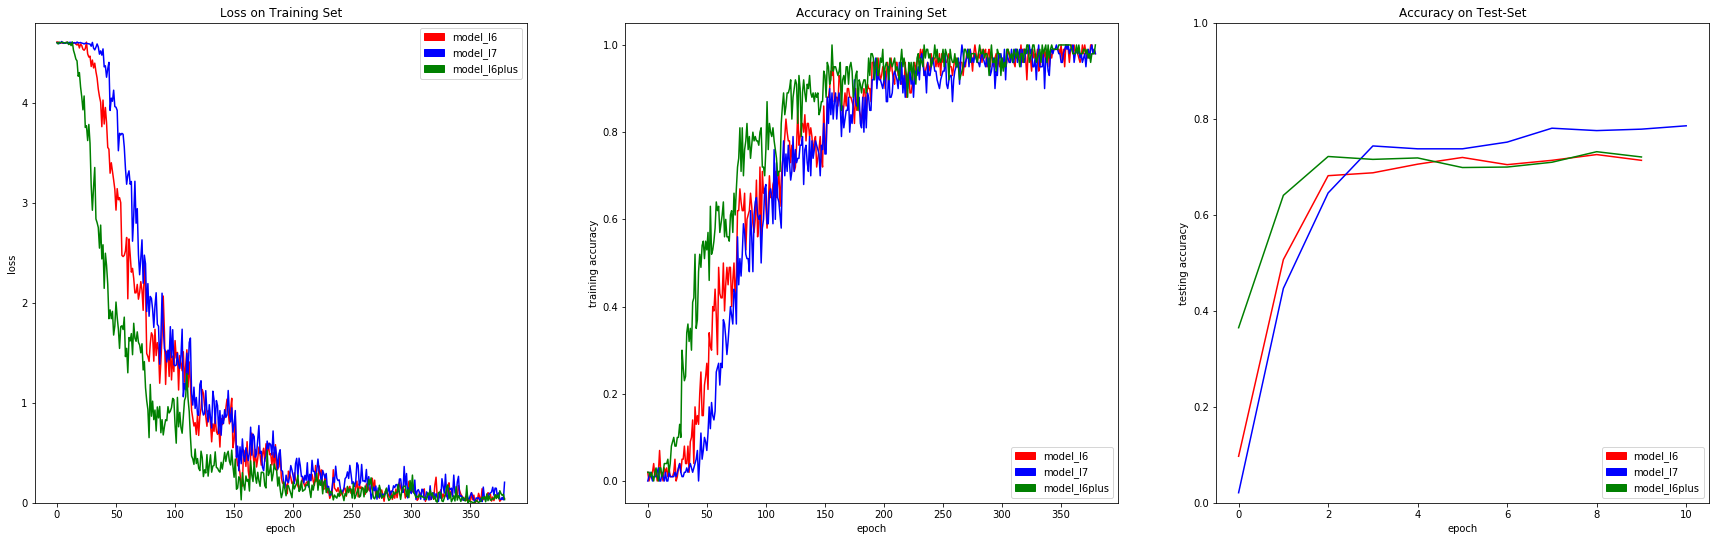

In [28]:
red_patch = mpatches.Patch(color='red', label='model_l6')
blue_patch = mpatches.Patch(color='blue', label='model_l7')
green_patch = mpatches.Patch(color='green', label='model_l6plus')

plt.figure(figsize=(30, 30))

plt.subplot(3,3,1)
plt.legend(handles=[red_patch,blue_patch,green_patch]
           , loc = 'upper right')
plt.title('Loss on Training Set')
plt.plot(model_l6.all_losses, 'red')
plt.plot(model_l7.all_losses, 'blue')
plt.plot(model_l6plus.all_losses, 'green')
plt.ylim(0,4.8)
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(3,3,2)
plt.legend(handles=[red_patch,blue_patch,green_patch]
           , loc = 'lower right')
plt.title('Accuracy on Training Set')
plt.plot(model_l6.train_accuracy, 'red')
plt.plot(model_l7.train_accuracy, 'blue')
plt.plot(model_l6plus.train_accuracy, 'green')
plt.ylabel('training accuracy')
plt.xlabel('epoch')

plt.subplot(3,3,3)
plt.legend(handles=[red_patch,blue_patch,green_patch]
           , loc = 'lower right')
plt.title('Accuracy on Test-Set')
plt.plot(model_l6.test_accuracy, 'red')
plt.plot(model_l7.test_accuracy, 'blue')
plt.plot(model_l6plus.test_accuracy, 'green')
plt.ylim(0,1)
plt.ylabel('testing accuracy')
plt.xlabel('epoch')

plt.show()

## Lastly Validate Accuracy On Validation-Set
We choose the model with highest accuracy on test-set, and use it to do prediction on our validation-set to see how is it's performance on data-set it has never seen.

In [22]:
AccuracyHelper(model_l7, dataloaders['validation'])

accuracy on test set: 78.600% 786


## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.